____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Estudio de data augmentation en audios de ballenas con modelos generativos__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [1]:
import os
import copy
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from src.models.classification import *
from src.models.generative import *
from src.preprocessing import *
from src.display import *
from src.metrics import *
from src.utils import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import KFold, ParameterGrid, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Definimos algunas variables globales

In [2]:
SPEC_CONFIG = {
    "SR": 2000,              # sampling rate
    "FFT_SAMPLES": 256,      # tamaño de la ventana
    "HOP_LENGTH": 63,        # salto entre frames
    "MEL_BINS": 64,          # frequency bins (resolución)
    "MAX_FREQ": 600          # máxima frecuencia para los espectrogramas
}

DATA_AUG_CONFIG = {
    'TIME_STRETCH_FACTORS': [0.9, 1.1],     # ±10%
    'PITCH_SHIFTS': [-2, 2],                # ±2 semitonos
    'NOISE_LEVEL': 0.001                    # ruido leve
}

SEED = 3    # semilla para reproducibilidad

### Cargamos los datos

In [3]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir, sampling_rate=SPEC_CONFIG['SR'])
print(audio_df.columns)

Index(['clip_name', 'label', 'filepath', 'audio'], dtype='object')


### Preparamos los datos para entrenar los modelos

In [4]:
normalize(audio_df, 'audio')

In [5]:
train_df, val_df = train_test_split(audio_df, test_size=0.2, random_state=SEED, stratify=audio_df['label'])

In [6]:
batch_size = 128
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print('Using device:', device)

Using device: mps


In [ ]:
train_mel_spec = []
for audio in train_df['audio']: 
    mel = get_melspectrogram(audio, SPEC_CONFIG['SR'], SPEC_CONFIG['FFT_SAMPLES'], SPEC_CONFIG['HOP_LENGTH'], SPEC_CONFIG['MEL_BINS'], SPEC_CONFIG['MAX_FREQ']) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    train_mel_spec.append(mel)

In [ ]:
val_mel_spec = []
for audio in val_df['audio']:
    mel = get_melspectrogram(audio, SPEC_CONFIG['SR'], SPEC_CONFIG['FFT_SAMPLES'], SPEC_CONFIG['HOP_LENGTH'], SPEC_CONFIG['MEL_BINS'], SPEC_CONFIG['MAX_FREQ']) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    val_mel_spec.append(mel)

In [9]:
X_train = np.array(train_mel_spec)
X_val = np.array(val_mel_spec)

y_train = train_df['label'].values
y_val = val_df['label'].values

In [10]:
X_train_std, X_val_std, train_mean, train_std = standarize_train_val(X_train, X_val)

Mean: -22.267026901245117, std: 10.529284487233888


In [11]:
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_std, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader_original = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader_original = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### Cargamos los modelos

#### Variational Autoencoder (VAE)

In [13]:
BVAE = load_model()

[✔] Modelo cargado desde: saved_models/bvae.pt


#### Adversarial Autoencoder (AAE)

In [15]:
AAE_encoder, AAE_decoder, AAE_discriminator = load_aae_models()

[✔] AAE cargado desde: saved_models/aae


#### Generative Adversarial Network (GAN)

In [17]:
specGAN, specDISC = load_gan_models(device, path_gen='saved_models/specgan/generator_epoch_200.pt', path_disc='saved_models/specgan/discriminator_epoch_200.pt')

[✔] Modelos cargados desde:
  - saved_models/specgan/generator_epoch_200.pt
  - saved_models/specgan/discriminator_epoch_200.pt


### Hacemos data augmentation

In [18]:
datos_totales = len(y_train)
audios_ballena = np.count_nonzero(y_train)
audios_ruido = datos_totales - audios_ballena
ballenas_faltantes = audios_ruido - audios_ballena

print(f'De los {datos_totales} datos que se usan para entrenar: {audios_ballena} son de ballena y {audios_ruido} son de ruido, por ende falta completar con {ballenas_faltantes} audios de ballena.')

De los 24000 datos que se usan para entrenar: 5622 son de ballena y 18378 son de ruido, por ende falta completar con 12756 audios de ballena.


In [19]:
print(f'X_train shape: {(X_train.shape)}')
print(f'y_train shape: {(y_train.shape)}')
latent_dim = 32

X_train shape: (24000, 1, 64, 64)
y_train shape: (24000,)


In [20]:
synth_labels = np.ones(ballenas_faltantes, dtype=int)

#### Armamos un dataset haciendo data augmentation sobre el audio

In [21]:
augmented_samples = augment_audio(train_df, DATA_AUG_CONFIG, percentage=0.3, sampling_rate=SPEC_CONFIG['SR'])
augmented_samples_df = pd.DataFrame(augmented_samples, columns=['clip_name', 'label', 'filepath', 'audio'])

augmented_train_audio_df = pd.concat([train_df, augmented_samples_df], ignore_index=True)

print(f'Original dataset: {len(train_df)} | Augmented dataset: {len(augmented_train_audio_df)}')

New augmented samples: 8430
Original dataset: 24000 | Augmented dataset: 32430


In [22]:
clip_name = "train18947"  # elegi cualquiera que haya sido aumentado

samples_df = augmented_train_audio_df[augmented_train_audio_df['clip_name'].str.contains(clip_name)]

for _, sample in samples_df.iterrows():
    print(sample['clip_name'])
    display(Audio(data=sample['audio'], rate=SPEC_CONFIG['SR']*1.5))

train18947.aiff


train18947.aiff_stretch_0.9.aiff


train18947.aiff_stretch_1.1.aiff


train18947.aiff_shift_-2.aiff


train18947.aiff_shift_2.aiff


train18947.aiff_noisy.aiff


In [23]:
train_augmented_mel_spec = []
for audio in augmented_train_audio_df['audio']: # emprolijar esto de abajo
    mel = get_melspectrogram(audio, SPEC_CONFIG['SR'], SPEC_CONFIG['FFT_SAMPLES'], SPEC_CONFIG['HOP_LENGTH'], SPEC_CONFIG['MEL_BINS'], SPEC_CONFIG['MAX_FREQ']) # shape: (64, 64)
    mel = mel[np.newaxis, :, :] # shape: (1, 64, 64)
    train_augmented_mel_spec.append(mel)

In [24]:
augmented_X_train = np.array(train_mel_spec)
augmented_y_train = train_df['label'].values

In [25]:
augmented_X_train = (augmented_X_train - train_mean)/train_std

In [26]:
augmented_X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
augmented_y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_loader_augmented = DataLoader(TensorDataset(augmented_X_train_tensor, augmented_y_train_tensor), batch_size=batch_size, shuffle=True)

#### Armamos un dataset con muestras generadas por el VAE

In [44]:
# estos son el mean y std con los que se estandarizaron los datos de train del vae y aae (solo los audios de ballena de train), estan en el otro notebook
gen_train_mean, gen_train_std = -21.889528274536133, 11.347515106201172

In [45]:
with torch.no_grad():
    z = torch.randn(ballenas_faltantes, latent_dim).to(device)
    synth_specs = BVAE.decode(z).cpu().numpy()  # shape: (n_synth, 1, 64, 64)
    synth_specs = synth_specs * gen_train_std + gen_train_mean

In [46]:
X_train_vae = np.concatenate([X_train, synth_specs], axis=0)
y_train_vae = np.concatenate([y_train, synth_labels], axis=0)

In [47]:
X_train_vae_std = (X_train_vae - train_mean) / train_std

In [48]:
X_train_vae_tensor = torch.tensor(X_train_vae_std, dtype=torch.float32)
y_train_vae_tensor = torch.tensor(y_train_vae, dtype=torch.long)

vae_train_loader = DataLoader(TensorDataset(X_train_vae_tensor, y_train_vae_tensor), batch_size=batch_size, shuffle=True)

#### Armamos un dataset con muestras generadas por el AAE

In [49]:
with torch.no_grad():
    z = torch.randn(ballenas_faltantes, latent_dim).to(device)
    synth_specs = AAE_decoder(z).cpu().numpy()
    synth_specs = synth_specs * gen_train_std + gen_train_mean 

In [50]:
X_train_aae = np.concatenate([X_train, synth_specs], axis=0)
y_train_aae = np.concatenate([y_train, synth_labels], axis=0)

In [51]:
X_train_aae_std = (X_train_aae - train_mean) / train_std

In [52]:
X_train_aae_tensor = torch.tensor(X_train_aae_std, dtype=torch.float32)
y_train_aae_tensor = torch.tensor(y_train_aae, dtype=torch.long)

aae_train_loader = DataLoader(TensorDataset(X_train_aae_tensor, y_train_aae_tensor), batch_size=batch_size, shuffle=True)

#### Armamos un dataset con muestras generadas por la GAN

In [57]:
# estos son los valores usados para normalizar, estan en el otro notebook
gan_low, gan_high = -44.76902141571045, -7.858511042594914

In [58]:
z_dim = 100
with torch.no_grad():
    z = torch.randn(ballenas_faltantes, z_dim).to(device)
    gan_specs = specGAN(z).cpu()
    gan_specs = robust_denormalize(gan_specs, gan_low, gan_high)

In [59]:
X_train_gan = np.concatenate([X_train, gan_specs], axis=0)
y_train_gan = np.concatenate([y_train, synth_labels], axis=0)

In [60]:
X_train_gan_std = (X_train_gan - train_mean) / train_std

In [61]:
X_train_gan_tensor = torch.tensor(X_train_gan_std, dtype=torch.float32)
y_train_gan_tensor = torch.tensor(y_train_gan, dtype=torch.long)

gan_train_loader = DataLoader(TensorDataset(X_train_gan_tensor, y_train_gan_tensor), batch_size=batch_size, shuffle=True)

### Entrenamos y evaluamos el rendimiento sobre el conjunto de validación

#### CNN con datos originales

Epoch 1/50 | Train Loss: 0.2829 | Val Loss: 0.2057 | Val Acc: 90.42% | Val F1: 0.8030 | Val AUC: 0.9627
Epoch 2/50 | Train Loss: 0.1920 | Val Loss: 0.1843 | Val Acc: 91.93% | Val F1: 0.8295 | Val AUC: 0.9705
Epoch 3/50 | Train Loss: 0.1732 | Val Loss: 0.1834 | Val Acc: 91.73% | Val F1: 0.8316 | Val AUC: 0.9718
Epoch 4/50 | Train Loss: 0.1621 | Val Loss: 0.1791 | Val Acc: 92.50% | Val F1: 0.8373 | Val AUC: 0.9734
Epoch 5/50 | Train Loss: 0.1550 | Val Loss: 0.1787 | Val Acc: 92.68% | Val F1: 0.8433 | Val AUC: 0.9730
Epoch 6/50 | Train Loss: 0.1469 | Val Loss: 0.1756 | Val Acc: 92.50% | Val F1: 0.8484 | Val AUC: 0.9750
Epoch 7/50 | Train Loss: 0.1365 | Val Loss: 0.1715 | Val Acc: 92.47% | Val F1: 0.8471 | Val AUC: 0.9750
Epoch 8/50 | Train Loss: 0.1222 | Val Loss: 0.1845 | Val Acc: 92.50% | Val F1: 0.8360 | Val AUC: 0.9741
Epoch 9/50 | Train Loss: 0.1133 | Val Loss: 0.1868 | Val Acc: 92.37% | Val F1: 0.8349 | Val AUC: 0.9734
Epoch 10/50 | Train Loss: 0.0976 | Val Loss: 0.2150 | Val Acc: 9

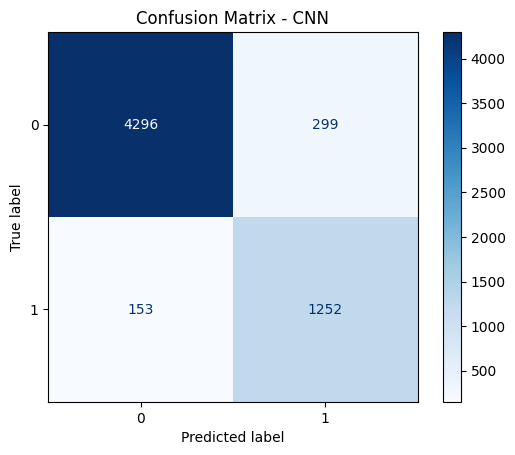

In [37]:
CNN = ConvolutionalMLP(output_dim=2)
CNN.train_model(train_loader_original, val_loader_original, epochs=50, early_stopping_patience=5, use_class_weights=False)
CNN.evaluate(val_loader_original)
CNN.confusion_matrix(val_loader_original)

#### CNN con datos originales y loss ponderada

Epoch 1/50 | Train Loss: 0.3258 | Val Loss: 0.2682 | Val Acc: 87.62% | Val F1: 0.7829 | Val AUC: 0.9624
Epoch 2/50 | Train Loss: 0.2067 | Val Loss: 0.2273 | Val Acc: 90.23% | Val F1: 0.8185 | Val AUC: 0.9708
Epoch 3/50 | Train Loss: 0.1878 | Val Loss: 0.1981 | Val Acc: 91.20% | Val F1: 0.8289 | Val AUC: 0.9720
Epoch 4/50 | Train Loss: 0.1765 | Val Loss: 0.1959 | Val Acc: 91.07% | Val F1: 0.8288 | Val AUC: 0.9741
Epoch 5/50 | Train Loss: 0.1659 | Val Loss: 0.2468 | Val Acc: 89.60% | Val F1: 0.8134 | Val AUC: 0.9744
Epoch 6/50 | Train Loss: 0.1552 | Val Loss: 0.2385 | Val Acc: 91.05% | Val F1: 0.8318 | Val AUC: 0.9758
Epoch 7/50 | Train Loss: 0.1412 | Val Loss: 0.2087 | Val Acc: 91.35% | Val F1: 0.8354 | Val AUC: 0.9744
Epoch 8/50 | Train Loss: 0.1313 | Val Loss: 0.2107 | Val Acc: 91.78% | Val F1: 0.8409 | Val AUC: 0.9745
Epoch 9/50 | Train Loss: 0.1165 | Val Loss: 0.2397 | Val Acc: 91.93% | Val F1: 0.8433 | Val AUC: 0.9745
Early stopping triggered (val loss did not improve).
Validation 

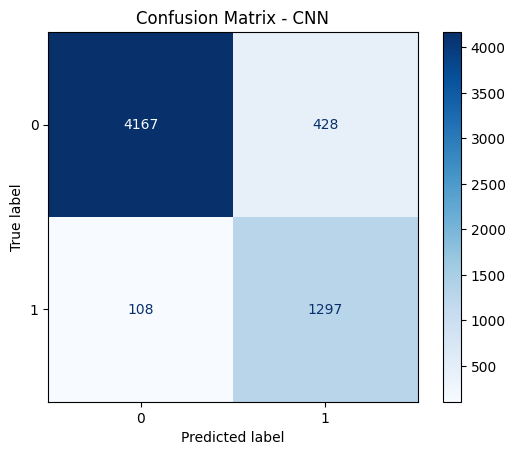

In [ ]:
CNN_weighted = ConvolutionalMLP(output_dim=2)
CNN_weighted.train_model(train_loader_original, val_loader_original, epochs=50, early_stopping_patience=5, use_class_weights=True)
CNN_weighted.evaluate(val_loader_original)
CNN_weighted.confusion_matrix(val_loader_original)

#### CNN con audios aumentados

Epoch 1/50 | Train Loss: 0.2978 | Val Loss: 0.2270 | Val Acc: 89.48% | Val F1: 0.7614 | Val AUC: 0.9584
Epoch 2/50 | Train Loss: 0.1969 | Val Loss: 0.1933 | Val Acc: 91.30% | Val F1: 0.8212 | Val AUC: 0.9675
Epoch 3/50 | Train Loss: 0.1781 | Val Loss: 0.1814 | Val Acc: 91.93% | Val F1: 0.8334 | Val AUC: 0.9715
Epoch 4/50 | Train Loss: 0.1662 | Val Loss: 0.1744 | Val Acc: 92.47% | Val F1: 0.8411 | Val AUC: 0.9739
Epoch 5/50 | Train Loss: 0.1566 | Val Loss: 0.1753 | Val Acc: 92.57% | Val F1: 0.8408 | Val AUC: 0.9749
Epoch 6/50 | Train Loss: 0.1481 | Val Loss: 0.1754 | Val Acc: 92.58% | Val F1: 0.8474 | Val AUC: 0.9750
Epoch 7/50 | Train Loss: 0.1384 | Val Loss: 0.1798 | Val Acc: 92.77% | Val F1: 0.8459 | Val AUC: 0.9748
Epoch 8/50 | Train Loss: 0.1261 | Val Loss: 0.1851 | Val Acc: 92.67% | Val F1: 0.8453 | Val AUC: 0.9744
Epoch 9/50 | Train Loss: 0.1155 | Val Loss: 0.1997 | Val Acc: 92.52% | Val F1: 0.8346 | Val AUC: 0.9732
Early stopping triggered (val loss did not improve).
Validation 

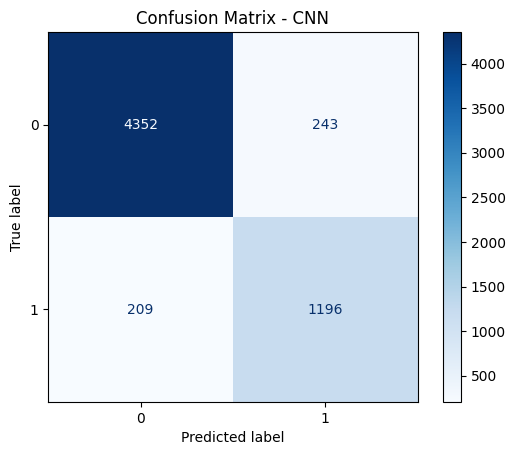

In [42]:
CNN_audio_augmented = ConvolutionalMLP(output_dim=2)
CNN_audio_augmented.train_model(train_loader_augmented, val_loader_original, epochs=50, early_stopping_patience=5, use_class_weights=False)
CNN_audio_augmented.evaluate(val_loader_original)
CNN_audio_augmented.confusion_matrix(val_loader_original)

#### CNN con muestras originales + muestras VAE

Epoch 1/50 | Train Loss: 0.2053 | Val Loss: 0.2447 | Val Acc: 89.53% | Val F1: 0.7556 | Val AUC: 0.9509
Epoch 2/50 | Train Loss: 0.1379 | Val Loss: 0.1922 | Val Acc: 91.30% | Val F1: 0.8141 | Val AUC: 0.9681
Epoch 3/50 | Train Loss: 0.1165 | Val Loss: 0.1846 | Val Acc: 92.08% | Val F1: 0.8252 | Val AUC: 0.9729
Epoch 4/50 | Train Loss: 0.1082 | Val Loss: 0.1734 | Val Acc: 92.42% | Val F1: 0.8342 | Val AUC: 0.9753
Epoch 5/50 | Train Loss: 0.1014 | Val Loss: 0.1778 | Val Acc: 92.45% | Val F1: 0.8408 | Val AUC: 0.9749
Epoch 6/50 | Train Loss: 0.0967 | Val Loss: 0.1893 | Val Acc: 91.68% | Val F1: 0.8401 | Val AUC: 0.9755
Epoch 7/50 | Train Loss: 0.0917 | Val Loss: 0.1825 | Val Acc: 92.38% | Val F1: 0.8312 | Val AUC: 0.9748
Epoch 8/50 | Train Loss: 0.0819 | Val Loss: 0.1725 | Val Acc: 92.52% | Val F1: 0.8384 | Val AUC: 0.9751
Epoch 9/50 | Train Loss: 0.0741 | Val Loss: 0.1922 | Val Acc: 91.57% | Val F1: 0.8092 | Val AUC: 0.9722
Epoch 10/50 | Train Loss: 0.0636 | Val Loss: 0.2271 | Val Acc: 9

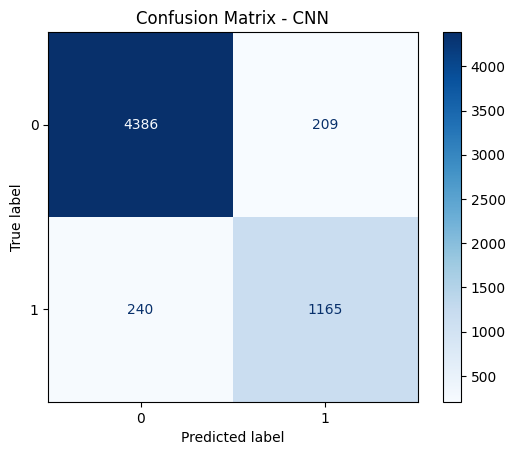

In [75]:
VAE_CNN = ConvolutionalMLP(output_dim=2)
VAE_CNN.train_model(vae_train_loader, val_loader_original, epochs=50, early_stopping_patience=5, use_class_weights=False)
VAE_CNN.evaluate(val_loader_original)
VAE_CNN.confusion_matrix(val_loader_original)

#### CNN con muestras originales + muestras AAE

Epoch 1/50 | Train Loss: 0.1918 | Val Loss: 0.2281 | Val Acc: 90.50% | Val F1: 0.7957 | Val AUC: 0.9568
Epoch 2/50 | Train Loss: 0.1268 | Val Loss: 0.1875 | Val Acc: 91.43% | Val F1: 0.8143 | Val AUC: 0.9695
Epoch 3/50 | Train Loss: 0.1103 | Val Loss: 0.1746 | Val Acc: 92.32% | Val F1: 0.8327 | Val AUC: 0.9736
Epoch 4/50 | Train Loss: 0.1012 | Val Loss: 0.1918 | Val Acc: 91.28% | Val F1: 0.7935 | Val AUC: 0.9737
Epoch 5/50 | Train Loss: 0.0956 | Val Loss: 0.1791 | Val Acc: 92.15% | Val F1: 0.8264 | Val AUC: 0.9736
Epoch 6/50 | Train Loss: 0.0892 | Val Loss: 0.1797 | Val Acc: 92.45% | Val F1: 0.8373 | Val AUC: 0.9743
Epoch 7/50 | Train Loss: 0.0803 | Val Loss: 0.1895 | Val Acc: 91.85% | Val F1: 0.8168 | Val AUC: 0.9731
Epoch 8/50 | Train Loss: 0.0711 | Val Loss: 0.1961 | Val Acc: 92.32% | Val F1: 0.8307 | Val AUC: 0.9735
Early stopping triggered (val loss did not improve).
Validation Loss: 0.1746, Accuracy: 92.32%, F1: 0.8327, AUC: 0.9736


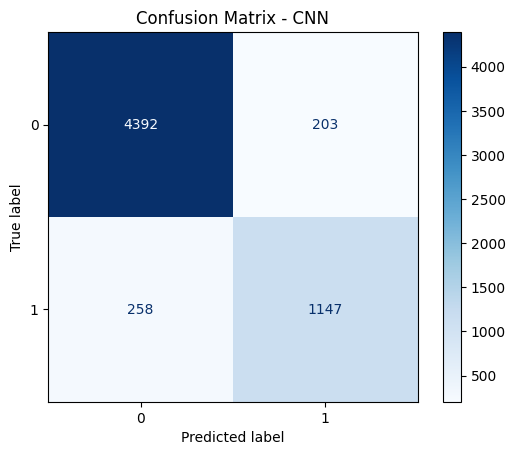

In [76]:
AAE_CNN = ConvolutionalMLP(output_dim=2)
AAE_CNN.train_model(aae_train_loader, val_loader_original, epochs=50, early_stopping_patience=5, use_class_weights=False)
AAE_CNN.evaluate(val_loader_original)
AAE_CNN.confusion_matrix(val_loader_original)

#### CNN con muestras originales + muestras GAN

Epoch 1/50 | Train Loss: 0.1964 | Val Loss: 0.2112 | Val Acc: 90.37% | Val F1: 0.7975 | Val AUC: 0.9607
Epoch 2/50 | Train Loss: 0.1256 | Val Loss: 0.1874 | Val Acc: 91.58% | Val F1: 0.8216 | Val AUC: 0.9694
Epoch 3/50 | Train Loss: 0.1110 | Val Loss: 0.1790 | Val Acc: 92.05% | Val F1: 0.8264 | Val AUC: 0.9727
Epoch 4/50 | Train Loss: 0.1032 | Val Loss: 0.1748 | Val Acc: 92.23% | Val F1: 0.8348 | Val AUC: 0.9740
Epoch 5/50 | Train Loss: 0.0969 | Val Loss: 0.1949 | Val Acc: 92.15% | Val F1: 0.8446 | Val AUC: 0.9742
Epoch 6/50 | Train Loss: 0.0923 | Val Loss: 0.1808 | Val Acc: 92.80% | Val F1: 0.8531 | Val AUC: 0.9737
Epoch 7/50 | Train Loss: 0.0840 | Val Loss: 0.1808 | Val Acc: 92.53% | Val F1: 0.8463 | Val AUC: 0.9740
Epoch 8/50 | Train Loss: 0.0776 | Val Loss: 0.1807 | Val Acc: 92.27% | Val F1: 0.8299 | Val AUC: 0.9740
Epoch 9/50 | Train Loss: 0.0708 | Val Loss: 0.2043 | Val Acc: 91.98% | Val F1: 0.8234 | Val AUC: 0.9717
Early stopping triggered (val loss did not improve).
Validation 

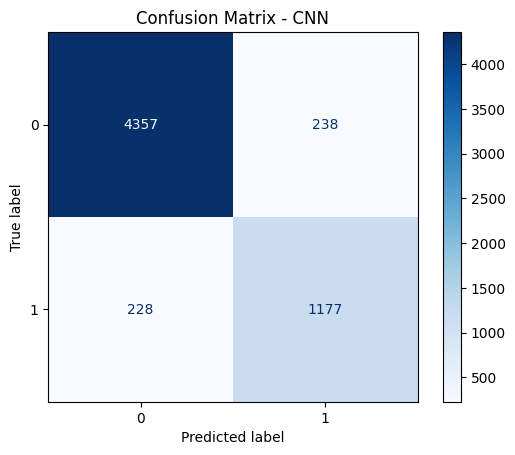

In [62]:
GAN_CNN = ConvolutionalMLP(output_dim=2)
GAN_CNN.train_model(gan_train_loader, val_loader_original, epochs=50, early_stopping_patience=5, use_class_weights=False)
GAN_CNN.evaluate(val_loader_original)
GAN_CNN.confusion_matrix(val_loader_original)

In [77]:
def plot_cnn_roc_curves(models, val_loader_cnn, y_val):

    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    roc_data = {}

    for model in models:
        mlp_probs = get_mlp_probs(models[model], val_loader_cnn, device)
        mlp_auc, mlp_fpr, mlp_tpr = compute_roc(y_val, mlp_probs)
        roc_data[model] = (mlp_auc, mlp_fpr, mlp_tpr)

    plt.figure(figsize=(10, 7))

    for name, (auc, fpr, tpr) in roc_data.items():
        plt.plot(fpr, tpr, label=f'{name} [AUC = {auc:.3f}]')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate',fontsize=15)
    plt.title('ROC Curves', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


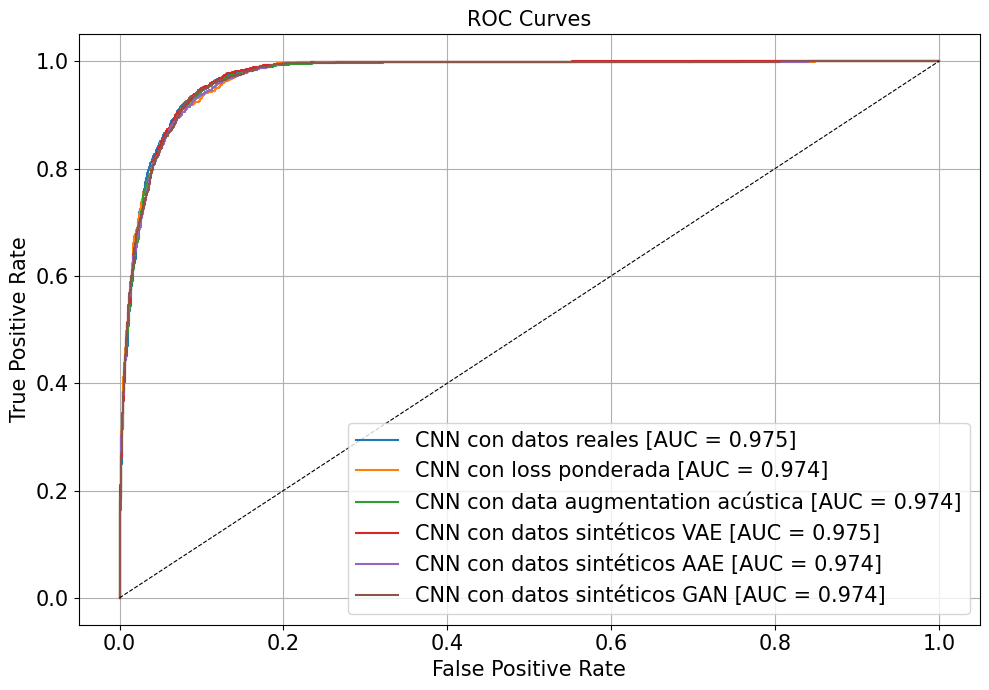

In [79]:
models = {
    'CNN con datos reales': CNN,
    'CNN con loss ponderada': CNN_weighted,
    'CNN con data augmentation acústica': CNN_audio_augmented,
    'CNN con datos sintéticos VAE': VAE_CNN,
    'CNN con datos sintéticos AAE': AAE_CNN,
    'CNN con datos sintéticos GAN': GAN_CNN
}

plot_cnn_roc_curves(models, val_loader_original, y_val)

In [ ]:
Validation Loss: 0.1715, Accuracy: 92.47%, F1: 0.8471, AUC: 0.9750
Validation Loss: 0.1959, Accuracy: 91.07%, F1: 0.8288, AUC: 0.9741 ponderada
Validation Loss: 0.1744, Accuracy: 92.47%, F1: 0.8411, AUC: 0.9739
Validation Loss: 0.1725, Accuracy: 92.52%, F1: 0.8384, AUC: 0.9751
Validation Loss: 0.1746, Accuracy: 92.32%, F1: 0.8327, AUC: 0.9736
Validation Loss: 0.1748, Accuracy: 92.23%, F1: 0.8348, AUC: 0.9740

Los modelos entrenados presentaron una loss sobre el conjunto de validación de 0.17, una accuracy de 0.92%, un F1-Score de 0.84+-1. Este fue el caso para todos los modelos menos para la red entrenada con datos reales y la loss ponderada, el cual presentó un rendimiento un poco peor con una loss loss sobre el conjunto de validación de 0.19.
